# "Gradient descent with Adam"
> "SGD, but with adaptive moms."

- comments: true
- categories: [fastai]

In [1]:
#hide
!pip install -Uqq fastai>=2.0.0 graphviz ipywidgets matplotlib nbdev>=0.2.12 pandas scikit_learn azure-cognitiveservices-search-imagesearch sentencepiece

In [2]:
#hide
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
#hide
from fastai.vision.all import *

## Introduction

An optimizer is a function used in the "step" phase of training where we update the weights based on the gradient of the loss at that point calculated during backpropagation. By default, fastai uses the Adam optimizer.

To compare Adam with previous optimizers, let's train a model using Adam with the Imagenette data set:

In [5]:
def get_dls(url, presize, resize):
    path = untar_data(url)
    Path.BASE_PATH = path
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files,
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)]
    ).dataloaders(path, bs=128)

In [6]:
#hide_output
dls = get_dls(URLs.IMAGENETTE_160, 160, 128)

In [9]:
def get_learner(**kwargs):
    return vision_learner(dls, resnet34, pretrained=False,
                       metrics=accuracy, **kwargs).to_fp16()

In [10]:
learn = get_learner()
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.515065,1.997084,0.380892,00:48
1,1.837666,1.562741,0.468790,01:01
2,1.487112,1.273339,0.580637,00:51


## It all started with SGD

At the beginning of my fastai journey, I first learned stochastic gradient descent, which I used to train a model on the MNIST data set. SGD looks like

```
new_weight = weight - lr * weight.grad
```

Let's train a model using SGD as its optimizer:

In [15]:
learn = get_learner(opt_func=SGD)

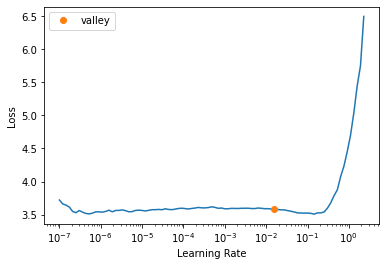

In [12]:
lr = learn.lr_find().valley

In [16]:
learn.fit_one_cycle(3, lr, moms=(0, 0, 0))

epoch,train_loss,valid_loss,accuracy,time
0,3.060603,3.215654,0.239490,00:46
1,2.578725,1.890918,0.344968,00:46
2,2.359712,1.807126,0.377580,00:47


## How to create different optimizers

Unlike previous deep learning libraries, fastai was innovative in that it allowed for callbacks in basically any part of the training process, allowing users to tweak the training process without having to change the actual library code. 

---

A callback is a piece of code that you write and inject somewhere in another piece of code. 

---

We can create different optimizers through *optimizer callbacks*, which allow us to change how the optimizer takes a step during the optimization step of the deep learning training cycle. 

`Optimizer` is a class provided by fastai that has two major functions, `zero_grad` and `step`:

```python
def zero_grad(self):
    for p,*_ in self.all_params(with_grad=True):
        p.grad.detach_()
        p.grad.zero_()

def step(self, closure=None):
    if closure is not None: raise NotImplementedError("fastai optimizers currently do not support closure")
    for p,pg,state,hyper in self.all_params(with_grad=True):
        for cb in self.cbs: state = _update(state, cb(p, **{**state, **hyper}))
        self.state[p] = state
```

When we update the gradients, we take a step using `step` and then zero the gradients using `zero_grad`, which are both automatically done by fastai's `Learner`. 

We can initialize `Optimizer` with a list of callbacks `cbs` that can update `state`. `state` is a dictionary that allows us to store variables as if we could update the code. 

Optimizer callbacks should ultimately update the parameters, shortened to `p` in the code. Then, using `state`, we can store intermediate values between different callbacks. 

So, we can create our own SGD like so and be able to get a similar result as before:

In [60]:
def sgd_cb(p, lr, **kwargs): 
    p.data.add_(p.grad.data, alpha=-lr)

In [61]:
opt_func = partial(Optimizer, cbs=[sgd_cb])

In [62]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 1.5e-2, moms=(0, 0, 0))

epoch,train_loss,valid_loss,accuracy,time
0,3.076169,3.106647,0.225987,00:45
1,2.625497,1.887920,0.358981,00:47
2,2.376982,1.792544,0.380382,00:46


## Adding momentum (SGD with momentum)

If our loss function is really noisy, the gradients may be constantly changing directions, which is bad. Instead, what if we "soften" the loss by forcing the gradients to change direction more slowly?

Momentum, according to the Cambridge dictionary, is a "force that keep an object moving". In terms of gradient descent, it's like continuing to descend in the previous direction for a while, rather than instantaneously changing direction. So, if we previously had:

```python
new_weight = weight - lr * weight.grad
```

Then we can add momentum by incorporating the previous gradients:

```python
weight.avg = beta * weight.avg + (1 - beta) * weight.grad
new_weight = weight - lr * weight.avg
```

Where `beta` is a parameter from 0 to 1 that controls how much momentum we want: as `beta` increases, we care less about the current gradient. 

In [66]:
def average_grad(p, mom, grad_avg=None, **kwargs):
    # mom is short for momentum
    if grad_avg is None:
        grad_avg = torch.zeros_like(p.grad.data)
    return {'grad_avg': mom * grad_avg + (1 - mom) * p.grad.data}

In [67]:
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(grad_avg, alpha=-lr)

In [68]:
opt_func = partial(Optimizer, cbs=[average_grad, momentum_step], mom=0.9)

In [70]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.971689,2.494611,0.292229,00:47
1,2.443049,1.767426,0.400255,00:47
2,2.192378,1.744862,0.414268,00:46


## Adding adaptive learning rates (RMSProp)

Not all parameters are going to be equal, so they also won't have the same gradients; some will be small, some will be large. So, why should we give them all the same learning rate? Here comes adaptive learning rates: we can speed up training by having a global learning rate, but use more of it the smaller the gradients are. 

We can have adaptive learning rates by dividing the current gradient by the average of the previous gradients. But, we can't just take the average of the gradients since the sum of similar positive and negative numbers will be 0 (hence, leading to a divide by zero). Instead, we take the square, then sum, then square root. 

```python
weight.square_avg = alpha * weight.square_avg + (1 - alpha) * (weight.grad ** 2)
new_weight        = weight - lr * weight.grad / math.sqrt(weight.square_avg + eps)
```

Now, we have two parameters: `alpha` and `eps`. `alpha` is like `beta` and `eps` (usually a small number like `1e-8`) is added for [numerical stability](https://mathworld.wolfram.com/NumericalStability.html). 

In [77]:
def average_square_grad(p, square_mom, square_avg=None, **kwargs):
    if square_avg is None: 
        square_avg = torch.zeros_like(p.grad.data)
    return {'square_avg': square_mom * square_avg + (1 - square_mom) * p.grad.data ** 2}

This method is called RMSProp since we're doing root-mean-squared propagation, hence `rms_prop_step`:

In [79]:
def rms_prop_step(p, lr, square_avg, eps, grad_avg=None, **kwargs):
    denom = square_avg.sqrt().add_(eps)
    p.data.addcdiv_(p.grad, denom, value=-lr)

In [80]:
opt_func = partial(Optimizer, cbs=[average_square_grad, rms_prop_step],
                   square_mom=0.99, eps=1e-8)

In [81]:
learn = get_learner(opt_func=opt_func)

In [83]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.801922,2.450024,0.147516,00:47
1,2.389270,2.579986,0.290955,00:48
2,1.955754,1.685765,0.450955,00:47


## **Ada**ptive learning rates and **m**omentum - Adam

You know, it would be nice if we could have both momentum for the gradients while also having adaptive learning rates. If only... oh, there's Adam. Hypothetically, Adam will stand for adaptive learning rates and momentum, where you take the moving average of the gradients for direction (we were just using the current gradient in RMSProp) and the moving average of the gradients squared for adaptive learning rates. 

However, instead of taking the moving average of the gradients, we take the *unbiased* moving average, which is:

```python
weight_avg   = beta * weight_avg + (1 - beta) * weight.grad
unbiased_avg = weight.avg / (1 - beta ** (i + 1))
```

Where we divide the moving average by `1 - beta ** (i + 1)` which becomes closer to 1 as `i`, the `i`-th iteration of `n` batches in an epoch, reaches `n`. The unbiased moving average will look more like the gradients at the beginning (`weight_avg` is initialized as `0`s so we don't want mostly `0` gradients at the beginning) and become closer to the normal moving average over time. 

Overall, Adam looks like:

```python
weight_avg   = beta * weight_avg + (1 - beta) * weight.grad
unbiased_avg = weight.avg / (1 - beta ** (i + 1))
weight.square_avg = alpha * weight.square_avg + (1 - alpha) * (weight.grad ** 2)
new_weight        = weight - lr * unbiased_avg / math.sqrt(weight.square_avg + eps)
```

The default for `(beta, alpha)` is `(0.9, 0.99)` and `eps` is `1e-8`. 

In the end, we get the combined benefits of momentum and adaptive learning rates to get:

In [ ]:
learn = get_learner()
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.515065,1.997084,0.380892,00:48
1,1.837666,1.562741,0.468790,01:01
2,1.487112,1.273339,0.580637,00:51


## The more correct weight decay school of thought

Weight decay can be thought in two ways. I mostly thought of it as adding the square of the weights to the loss, where it can instead be added to the gradient like: 

```python
weight.grad += wd * weight
```

The other way is to decay the weights by `lr * wd` and add it to the new weights like

```python
new_weight = weight - lr * weight.grad - lr * wd * weight
```

The two are equivalent through the lens of vanilla SGD. However, when we introduce momentum, we can no longer think of it as adding `wd * weight` to `weight.grad` since we'd end up having something like:

```python
weight_avg = beta * weight_avg + (1 - beta) * (weight.grad + wd * weight)
```

Instead, we use the second method. With Adam, it would look like:

```python
new_weight = weight - lr * unbiased_avg / math.sqrt(weight.square_avg + eps) - lr * wd * weight
```

## Conclusion

Althought fastai uses Adam as its default optimizer, which you can verify with the summary we had in [this blog](https://geon-youn.github.io/DunGeon/vision/2022/04/30/Convolutional-Neural-Networks.html), there are also a variety of other ones that fastai provides [here](https://github.com/fastai/fastai/blob/master/nbs/12_optimizer.ipynb). The main takeaway for this blog would be momentum and adaptive learning rates.

Momentum allows us to train the model with more stability since we aren't instantaneously changing direction according to the new gradients. Instead, we slowly change direction through a moving average of the previous gradients.

With the idea of moving averages, we have adaptive learning rates that allow each parameter to be special and learn at its own, although forcefully accelerated, pace. 

Combining these two ideas give us Adam, which has shown to be much more efficient than vanilla SGD, and using only one of the two ideas (SGD with momentum and RMSProp).